# Breast Cancer Patient Outcomes

## Problem Statement

Breast Cancer is a very serious disease. The possibility of terminal illness is terrifying for patients and their families. As such, an accurate prognosis, a prediction of a case's likely outcome, is extremely important. This project aims to train a supervised learning model to make accurate predictions of breast cancer case outcomes. That is to say, given a list of predictors this model should be able to accurately predict whether or not the case will be fatal.

## Summary of Results

As we will see below, the optimal prediction accuracy that I am able to achieve on this dataset is $81.1\%$. This performance remains constant across Logistic Regression, Random Forest, and Support Vector Machine approaches, though the Support Vector Machine is the only model that is able to achieve this accuracy without any significant tuning.

## Exploring the Data
This dataset was uploaded to Kaggle by Kreesh Rajani and can be found here: 
https://www.kaggle.com/datasets/kreeshrajani/breast-cancer-survival-dataset

Looking at the dataframe head below, we can see that we have 14 possible predictors for our 1 outcome variable, Patient_Status. Patient_Status is a binary variable, bluntly given as (Alive/Dead), which gives us the patient outcome.

In [20]:
import pandas as pd
import numpy as np

df = pd.read_csv('breast_cancer_survival.csv')
df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,42,FEMALE,0.95256,2.15000,0.007972,-0.048340,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,20-May-18,26-Aug-18,Alive
1,54,FEMALE,0.00000,1.38020,-0.498030,-0.507320,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,26-Apr-18,25-Jan-19,Dead
2,63,FEMALE,-0.52303,1.76400,-0.370190,0.010815,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Lumpectomy,24-Aug-18,08-Apr-20,Alive
3,78,FEMALE,-0.87618,0.12943,-0.370380,0.132190,I,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,16-Nov-18,28-Jul-20,Alive
4,42,FEMALE,0.22611,1.74910,-0.543970,-0.390210,II,Infiltrating Ductal Carcinoma,Positive,Positive,Positive,Lumpectomy,12-Dec-18,05-Jan-19,Alive


Below we can see a summary of the numerical data. We have 334 total rows, there are only NA values in two columns: Date_of_Last_Visit and Patient_Status. 

In [21]:
print(df.describe())

print('\nNA counts:')
print(df.isna().sum())

              Age    Protein1    Protein2    Protein3    Protein4
count  334.000000  334.000000  334.000000  334.000000  334.000000
mean    58.886228   -0.029991    0.946896   -0.090204    0.009819
std     12.961212    0.563588    0.911637    0.585175    0.629055
min     29.000000   -2.340900   -0.978730   -1.627400   -2.025500
25%     49.000000   -0.358888    0.362173   -0.513748   -0.377090
50%     58.000000    0.006129    0.992805   -0.173180    0.041768
75%     68.000000    0.343598    1.627900    0.278353    0.425630
max     90.000000    1.593600    3.402200    2.193400    1.629900

NA counts:
Age                    0
Gender                 0
Protein1               0
Protein2               0
Protein3               0
Protein4               0
Tumour_Stage           0
Histology              0
ER status              0
PR status              0
HER2 status            0
Surgery_type           0
Date_of_Surgery        0
Date_of_Last_Visit    17
Patient_Status        13
dtype: int64


### Cleaning the Data

The NA values for Patient_Status are especially problematic but there are not very many of them, so we will drop the NA value rows. We can see below that we end up with 317 rows so we have only lost about $5\%$ of our data.

In [22]:
df = df.dropna()
print(df.describe())

              Age    Protein1    Protein2    Protein3    Protein4
count  317.000000  317.000000  317.000000  317.000000  317.000000
mean    58.725552   -0.027232    0.949557   -0.095104    0.006713
std     12.827374    0.543858    0.906153    0.589027    0.625965
min     29.000000   -2.144600   -0.978730   -1.627400   -2.025500
25%     49.000000   -0.350600    0.368840   -0.531360   -0.382240
50%     58.000000    0.005649    0.997130   -0.193040    0.038522
75%     67.000000    0.336260    1.612000    0.251210    0.436250
max     90.000000    1.593600    3.402200    2.193400    1.629900


A few columns have spaces in their column names which could cause some syntax problems later on so I will rename those to remove the space. They all end in the word 'status' so I will drop that as well. Once that is done, we turn our attention to our non-numeric data. 

In the Gender column, I will map 'FEMALE' to 0 and 'MALE' to 1. For ER, PR, and HER2 I will map 'Negative' to 0 and 'Positive' to 1. For the Tumour_Stage variable, I will map each roman numeral to its corresponding integer. The 'Histology' column has three possible values: 'Infiltrating Ductal Carcinoma', 'Infiltrating Lobular Carcinoma', and 'Mucinous Carcinoma' which I will map to 0, 1, and 2 respectively. The 'Surgery_type' columns has the following values: 'Other', 'Lumpectomy', 'Modified Radical Mastectomy', and 'Simple Mastectomy' which I will map to 0, 1, 2, and 3 respectively.

Under the assumption that particular surgery dates or particular appointment dates have no meaningful impact (i.e. meeting with one's doctor on a Tuesday does not increase one's chances of survival), but may introduce additional noise, we will drop these columns. It is entirely possible that this assumption is mistaken and for an applied study a domain expert should be consulted.

Finally, our target variable 'Patient_Status' has two values: 'Dead' and 'Alive' which I will map to 0, and 1 respectively.

Our final dimensions then are 317 rows with 12 predictors for our target variable.

Our new, clean dataframe looks like this:

In [23]:
df = df.rename(columns={'ER status': 'ER', 'PR status': 'PR', 'HER2 status': 'HER2'})

df['Gender'] = df['Gender'].map({'FEMALE' : 0, 'MALE' : 1})

df['ER'] = df['ER'].map({'Negative' : 0, 'Positive' : 1})

df['PR'] = df['PR'].map({'Negative' : 0, 'Positive' : 1})

df['HER2'] = df['HER2'].map({'Negative' : 0, 'Positive' : 1})

df['Tumour_Stage'] = df['Tumour_Stage'].map({'I' : 1, 'II' : 2, 'III': 3, 'IV': 4})

df['Histology'] = df['Histology'].map({'Infiltrating Ductal Carcinoma' : 0, 'Infiltrating Lobular Carcinoma' : 1, 'Mucinous Carcinoma' : 2})

df['Surgery_type'] = df['Surgery_type'].map({'Other' : 0, 'Lumpectomy' : 1, 'Modified Radical Mastectomy' : 2,'Simple Mastectomy' : 3})

df = df.drop(columns=['Date_of_Surgery', 'Date_of_Last_Visit'], axis=1)

df['Patient_Status'] = df['Patient_Status'].map({'Dead' : 0, 'Alive' : 1})

df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER,PR,HER2,Surgery_type,Patient_Status
0,42,0,0.95256,2.15000,0.007972,-0.048340,2,0,1,1,0,0,1
1,54,0,0.00000,1.38020,-0.498030,-0.507320,2,0,1,1,0,0,0
2,63,0,-0.52303,1.76400,-0.370190,0.010815,2,0,1,1,0,1,1
3,78,0,-0.87618,0.12943,-0.370380,0.132190,1,0,1,1,0,0,1
4,42,0,0.22611,1.74910,-0.543970,-0.390210,2,0,1,1,1,1,1


### Visualizations

#### Non-Categorical Parameters
Now that we have made our data useable, let's check that there is no troubling multicollinearity in our non-categorical data. Looking at the pairplot below, it looks like we're safe. 

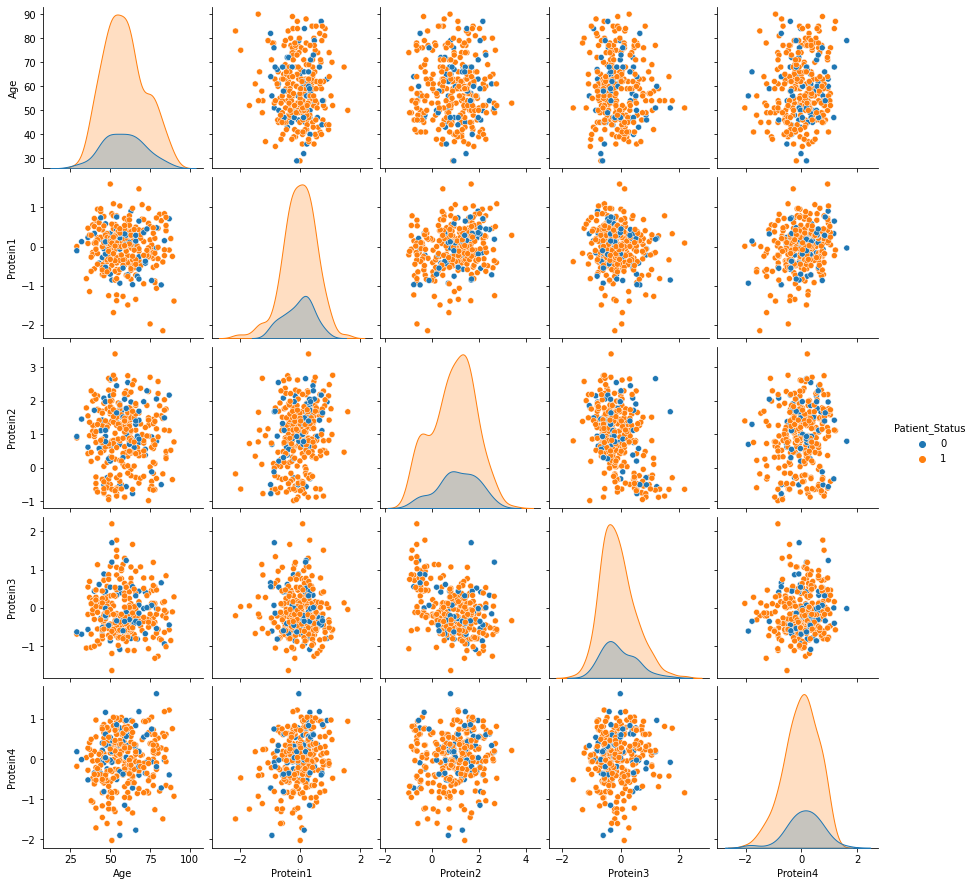

In [24]:
import seaborn

noncat = pd.DataFrame(df, columns=['Age', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Patient_Status'])

seaborn.pairplot(noncat, hue ='Patient_Status')

But to be certain, I've also constructed a heatmap for correlations of those predictors, which also looks ok.

<AxesSubplot:>

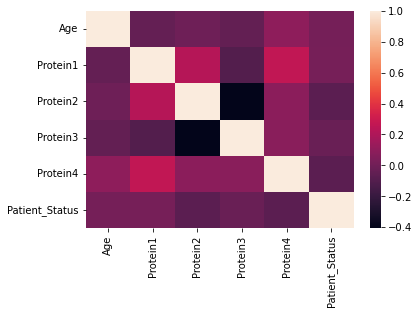

In [25]:
seaborn.heatmap(noncat.corr())

#### Categorical Data

Let's repeat this process then for our categorical data. We can see below that pairplots are not super helpful for categorical data, so again I've provided a correlation heatmap as well.

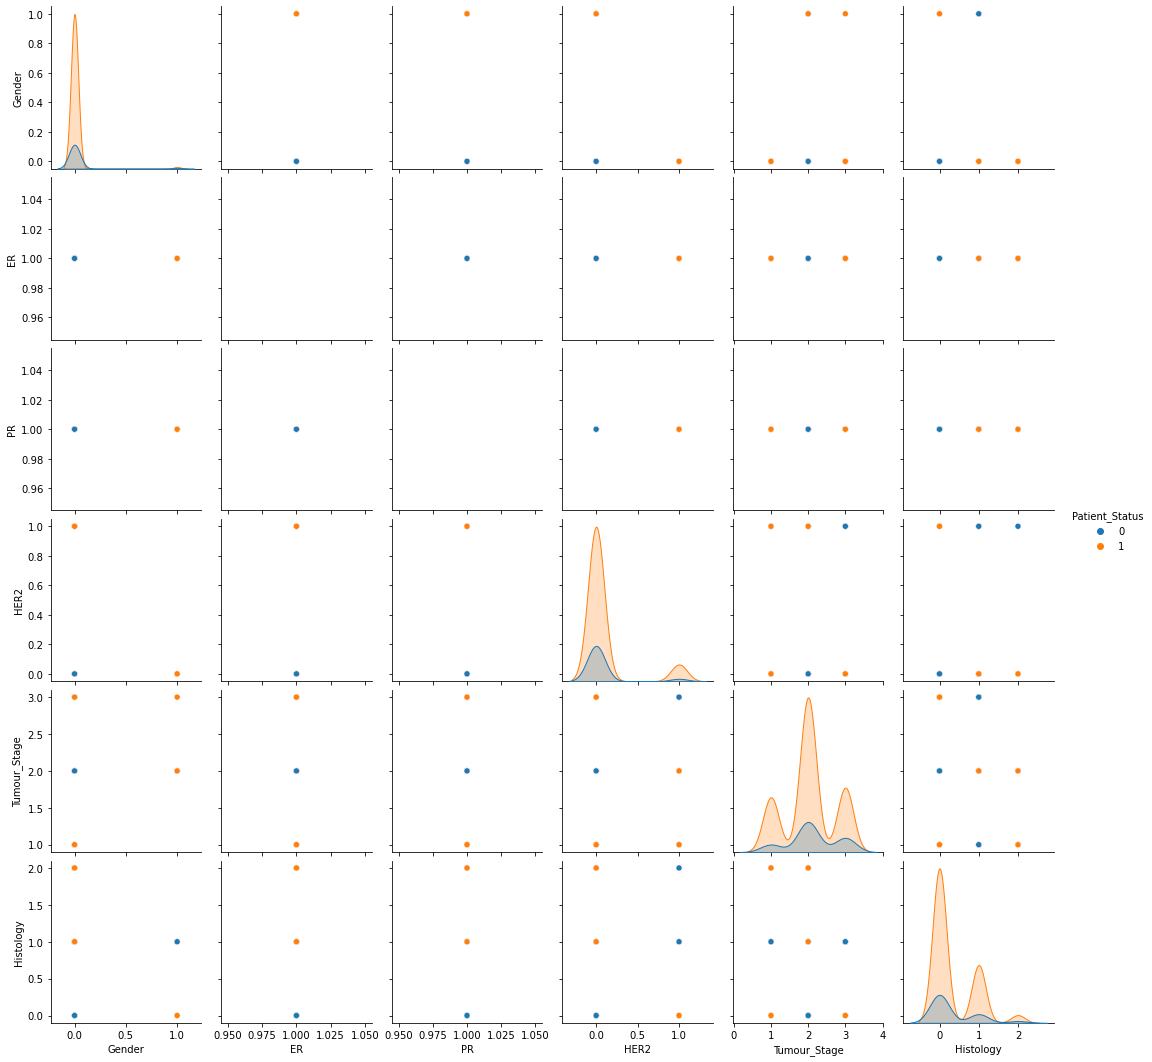

In [26]:
cat = pd.DataFrame(df, columns=['Gender', 'ER', 'PR', 'HER2', 'Tumour_Stage', 'Histology', 'Patient_Status'])

seaborn.pairplot(cat, hue ='Patient_Status')

<AxesSubplot:>

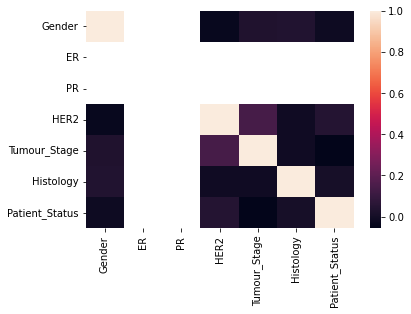

In [27]:
seaborn.heatmap(cat.corr())

So, it looks like we're all set to begin modeling!

## Modeling the Data

Now that our data is clean, we can split it for training and testing. I played around a bit with test and training sizes and with this dataset it seems like we get the best results when test size is relatively large. This makes sense, we don't want to be testing on a small sample. Thus, I've set the test size here to 70% of the data. For reproducibility, I've set random_state to 0.

In [28]:
from sklearn.model_selection import train_test_split

x = df.iloc[:,:-1]

y = df.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.7, random_state=0)


### Logistic Regression
Now that our training and testing data is split we can start our modeling process. Because this problem has a binary target value, this is a classification problem. Below we see a first pass at a logistic regression model using all possible predictors. The results are not impressive but not hopeless. This may point to a possible issue in our choice (or lack thereof) of predictors.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

reg_mod = LogisticRegression().fit(x_train, y_train)

y_pred = reg_mod.predict(x_test)

print('Accuracy of first Logistic Regression model: ' + str(round(accuracy_score(y_pred, y_test),3)))

Accuracy of first Logistic Regression model: 0.797


#### Feature Selection

Sci-Kit Learn provides a handy tool for feature selection. The SequentialFeatureSelector will perform forward or backward selection and return the optimal features given a particular number of features to select.

In [30]:
from sklearn.feature_selection import SequentialFeatureSelector
feature_names = np.array(x_train.columns)

for i in range(1,12):
    log_reg = LogisticRegression()
    forward_selector = SequentialFeatureSelector(log_reg, n_features_to_select=i, direction='forward').fit(x_train,y_train)
    features = feature_names[forward_selector.get_support()]
    print(features)


['Age']
['Age' 'Gender']
['Age' 'Gender' 'Protein2']
['Age' 'Gender' 'Protein1' 'Protein2']
['Age' 'Gender' 'Protein1' 'Protein2' 'Protein3']
['Age' 'Gender' 'Protein1' 'Protein2' 'Protein3' 'Protein4']
['Age' 'Gender' 'Protein1' 'Protein2' 'Protein3' 'Protein4' 'Tumour_Stage']
['Age' 'Gender' 'Protein1' 'Protein2' 'Protein3' 'Protein4' 'Tumour_Stage'
 'Histology']
['Age' 'Gender' 'Protein1' 'Protein2' 'Protein3' 'Protein4' 'Tumour_Stage'
 'Histology' 'HER2']
['Age' 'Gender' 'Protein1' 'Protein2' 'Protein3' 'Protein4' 'Tumour_Stage'
 'Histology' 'ER' 'HER2']
['Age' 'Gender' 'Protein1' 'Protein2' 'Protein3' 'Protein4' 'Tumour_Stage'
 'Histology' 'ER' 'PR' 'HER2']


Below I trained a series of models using each set of features. We can see that accuracy goes down beyond 3 features.

In [31]:
nfeatures = 1

x = x_train[['Age']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

x = x_train[['Age', 'Gender']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age', 'Gender']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

x = x_train[['Age', 'Gender', 'Protein2']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age', 'Gender', 'Protein2']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

x = x_train[['Age', 'Gender', 'Protein1', 'Protein2']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age', 'Gender', 'Protein1', 'Protein2']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

x = x_train[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

x = x_train[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

x = x_train[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

x = x_train[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage','Histology']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage','Histology']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

x = x_train[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage','Histology', 'HER2']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage','Histology', 'HER2']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

x = x_train[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage','Histology', 'ER', 'HER2']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage','Histology', 'ER', 'HER2']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

x = x_train[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage','Histology', 'ER', 'PR', 'HER2']]
model = LogisticRegression().fit(x, y_train)
y_pred = model.predict(x_test[['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage','Histology', 'ER', 'PR', 'HER2']])
score = accuracy_score(y_pred, y_test)
print('With ' + str(nfeatures) + ' features, accuracy is '+ str(score))
nfeatures += 1

With 1 features, accuracy is 0.8108108108108109
With 2 features, accuracy is 0.8108108108108109
With 3 features, accuracy is 0.8108108108108109
With 4 features, accuracy is 0.8063063063063063
With 5 features, accuracy is 0.8063063063063063
With 6 features, accuracy is 0.8063063063063063
With 7 features, accuracy is 0.8018018018018018
With 8 features, accuracy is 0.8063063063063063
With 9 features, accuracy is 0.8063063063063063
With 10 features, accuracy is 0.8063063063063063
With 11 features, accuracy is 0.8063063063063063


Let's see what set of features backward selection recommends. We'll assume that 3 features is the sweet spot. We see below that backward selection ends up agreeing that Age, Gender, and Protein2 are our best predictors.

In [32]:
backward_selector = SequentialFeatureSelector(log_reg, n_features_to_select=3, direction='backward').fit(x_train,y_train)
features = feature_names[backward_selector.get_support()]
print(features)

['Protein4' 'Tumour_Stage' 'Histology']


So, our two final logistic regression model here each use 3 features, 'Age', 'Gender', and 'Protein2' for the forward-selected model, 'Protein4','Tumour_Stage', and 'Histology' for the backward-selected model. As we can see below, both have an accuracy of $81.1\%$ Which is better than where we started but still not great.

In [33]:
x = x_train[['Age', 'Gender', 'Protein2']]
log_mod = LogisticRegression().fit(x, y_train)
y_pred = log_mod.predict(x_test[['Age', 'Gender', 'Protein2']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of final forward-selected logistic regression model is: ' + str(round(score,3)))

x = x_train[['Protein4','Tumour_Stage','Histology']]
final_log_mod = LogisticRegression().fit(x, y_train)
y_pred = final_log_mod.predict(x_test[['Protein4','Tumour_Stage','Histology']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of final backward-selected logistic regression model is: ' + str(round(score,3)))

Accuracy of final forward-selected logistic regression model is: 0.811
Accuracy of final backward-selected logistic regression model is: 0.811


##### The Gender Parameter

It is interesting that 'Gender' is such an important predictor. It's worth exploring further why that is. Because I've set 'Dead' to 0 and 'Alive' to 1 in the 'Patient_Status' column, the mean of that column is also the survival rate. Below I've separated female and male patients and calculated their survival rates.

In [34]:
females = df.loc[df['Gender'] == 0]

print('Female survival rate: ' + str(females['Patient_Status'].mean()))

males = df.loc[df['Gender'] == 1]

print('Male survival rate: ' + str(males['Patient_Status'].mean()))

Female survival rate: 0.805111821086262
Male survival rate: 0.75


We can see that female survival rate is notably higher than the male survival rate. We might think that this is due to females being more likely to be screened or more likely to be diagnosed early for some other reason but we would have to consult a domain expert to be certain. For now, let's try looking at just the female patients and see what that does to our selection of predictors and subsequent accuracy.

In [35]:
females = females.drop(columns=['Gender'])

fx = females.iloc[:,:-1]

fy = females.iloc[:,-1]



Since our dataset is even smaller now, I will increase our test size to 85% of the data to be safe.

In [36]:
fx_train, fx_test, fy_train, fy_test = train_test_split(fx, fy, test_size=.85, random_state=0)

In [37]:


reg_mod = LogisticRegression().fit(fx_train, fy_train)

y_pred = reg_mod.predict(fx_test)

print('Accuracy of full Logistic Regression model: ' + str(round(accuracy_score(y_pred, fy_test),3)))

Accuracy of full Logistic Regression model: 0.801


Accuracy of the full model, the model using all predictors, seems to improve! That's promising. Let's try selecting our best predictors then. We'll keep assuming that 3 predictors is best.

In [38]:
feature_names = np.array(fx_train.columns)

forward_selector = SequentialFeatureSelector(log_reg, n_features_to_select=3, direction='forward').fit(fx_train,fy_train)
features = feature_names[forward_selector.get_support()]
print(features)

backward_selector = SequentialFeatureSelector(log_reg, n_features_to_select=3, direction='backward').fit(fx_train,fy_train)
features = feature_names[backward_selector.get_support()]
print(features)

['Age' 'Protein1' 'Protein3']
['ER' 'PR' 'HER2']


We get a new set of features: 'Age', 'Protein1', and 'Protein3' from forward-selection; 'PR', 'HER2', and 'Surgery_type' from backward-selection. Below, I've trained two models using these predictors. We can see that the forward-selected model appears to perform now better than the full model but the backward selected model is slightly improved, though interestingly, it still performs worse than the model that was trained on data from both 'Gender' values.

In [39]:
fx =fx_train[['Age','Protein1','Protein3']]
log_mod = LogisticRegression().fit(fx, fy_train)
y_pred = log_mod.predict(fx_test[['Age','Protein1','Protein3']])
score = accuracy_score(y_pred, fy_test)
print('Accuracy of forward-selected logistic regression model is: ' + str(round(score,3)))

fx = fx_train[['PR','HER2', 'Surgery_type']]
log_mod = LogisticRegression().fit(fx, fy_train)
y_pred = log_mod.predict(fx_test[['PR', 'HER2', 'Surgery_type']])
score = accuracy_score(y_pred, fy_test)
print('Accuracy of backward-selected logistic regression model is: ' + str(round(score,3)))

Accuracy of forward-selected logistic regression model is: 0.801
Accuracy of backward-selected logistic regression model is: 0.809


#### Solver Selection

So, our best prediction model, the backward-selected model trained on the full data set, uses 3 predictors: 'Protein4', 'Tumour_Stage', and 'Histology'. Up until now, I've been using LogisticRegression's default solver, 'lbgs'. It's worth confirming that this solver in fact produces the best results. Below, using these same predictors, I've trained a series of models using the other solver options. We can see that there is no substantial difference in predictive accuracy.

In [40]:
x = x_train[['Protein4','Tumour_Stage','Histology']]
log_mod = LogisticRegression(solver='liblinear').fit(x, y_train)
y_pred = log_mod.predict(x_test[['Protein4','Tumour_Stage','Histology']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of liblinear model is: ' + str(round(score,3)))

log_mod = LogisticRegression(solver='newton-cg').fit(x, y_train)
y_pred = log_mod.predict(x_test[['Protein4','Tumour_Stage','Histology']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of newton-cg model is: ' + str(round(score,3)))

log_mod = LogisticRegression(solver='newton-cholesky').fit(x, y_train)
y_pred = log_mod.predict(x_test[['Protein4','Tumour_Stage','Histology']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of newton-cholesky model is: ' + str(round(score,3)))

log_mod = LogisticRegression(solver='sag').fit(x, y_train)
y_pred = log_mod.predict(x_test[['Protein4','Tumour_Stage','Histology']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of sag model is: ' + str(round(score,3)))

log_mod = LogisticRegression(solver='saga').fit(x, y_train)
y_pred = log_mod.predict(x_test[['Protein4','Tumour_Stage','Histology']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of saga model is: ' + str(round(score,3)))

Accuracy of liblinear model is: 0.811
Accuracy of newton-cg model is: 0.811
Accuracy of newton-cholesky model is: 0.811
Accuracy of sag model is: 0.811
Accuracy of saga model is: 0.811


We saw in the final lecture of class, though, that Logistic Regression is frequently outperformed by other approaches. Random Forest, in particular, seems to outperform our other approaches. Let's see if that is the case here.

### Random Forest

To begin, I trained a RandomForestClassifier, again from Sci-Kit Learn, on the full data with all of the predictors. For reproducibility, I've set the random_state to 0. We end up with an accuracy of $80.6\%$. This is better than the full model for Logistic Regression, though not as good as our final model from the Logistic Regression.

In [41]:
from sklearn.ensemble import RandomForestClassifier

for_mod = RandomForestClassifier(random_state=0).fit(x_train, y_train)

y_pred = for_mod.predict(x_test)

score = accuracy_score(y_pred, y_test)

print('Random Forest accuracy: ' +str(round(score,3)))

Random Forest accuracy: 0.806


#### Feature Selection

Next, I've run the SequentialFeatureSelector both forward and backward to select our optimal features. As we can see below, the forward selector gives us 'Gender', 'Tumour_Stage', and 'ER', while the backward selector gives us 'Tumour_Stage', 'PR', and 'HER2'. Note that this differs from the features selected for the logistic regression.

In [42]:
feature_names = np.array(x_train.columns)

rfc = RandomForestClassifier()

forward_selector = SequentialFeatureSelector(rfc, n_features_to_select=3, direction='forward').fit(x_train,y_train)
features = feature_names[forward_selector.get_support()]
print(features)

backward_selector = SequentialFeatureSelector(rfc, n_features_to_select=3, direction='backward').fit(x_train,y_train)
features = feature_names[backward_selector.get_support()]
print(features)

['Gender' 'Tumour_Stage' 'ER']
['Protein3' 'Protein4' 'Tumour_Stage']


Below, I've trained to RandomForestClassifiers using only the three predictors selected from the above two lists. This does improve our accuracy, however, we end up with the same predictive accuracy, $81.1\%$ as the best Logistic Regression model. 

In [43]:

for_mod = RandomForestClassifier().fit(x_train[['Gender', 'Tumour_Stage', 'ER']], y_train)
y_pred = for_mod.predict(x_test[['Gender', 'Tumour_Stage', 'ER']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of the forward-selected model is ' + str(round(score,3)))

for_mod = RandomForestClassifier().fit(x_train[['Tumour_Stage', 'PR', 'HER2']], y_train)
y_pred = for_mod.predict(x_test[['Tumour_Stage', 'PR', 'HER2']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of the backward-selected model is ' + str(round(score,3)))

Accuracy of the forward-selected model is 0.811
Accuracy of the backward-selected model is 0.811


#### Hyperparameter Tuning

Features are not the only parameters to consider here, however, as the RandomForestClassifier has a number of hyperparameters. Below, I've used GridSearchCV to find the optimal hyperparameters. I've used the full model, rather than just the predictors selected previously. We find that the best set of parameters is {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'warm_start': True}. 

In [44]:
from sklearn.model_selection import cross_val_score, GridSearchCV

param_grid = {'criterion':['gini', 'entropy', 'log_loss'], 
              'max_depth': [1,2,3,4,5],
              'max_features': ['sqrt', 'log2'],
              'bootstrap': [True, False],
              'warm_start': [True,False],
              }

grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid).fit(x_train,y_train)

print(grid.best_params_)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'warm_start': True}


#### Optimal Random Forest Models

Training a RandomForestClassifier on the full data we get an accuracy of $81.1\%$ which is as good as our previous models that were restricted to our selected predictors.

In [45]:
for_mod = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=1, max_features='sqrt', warm_start=True, random_state=0).fit(x_train, y_train)
y_pred = for_mod.predict(x_test)
score = accuracy_score(y_pred, y_test)
print('Best Parameter Random Forest accuracy: ' +str(round(score,3)))

Best Parameter Random Forest accuracy: 0.811


Using these parameters on the restricted sets of predictors yields the same results.

In [46]:
for_mod = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=1, max_features='sqrt', warm_start=True, random_state=0).fit(x_train[['Gender', 'Tumour_Stage', 'ER']], y_train)
y_pred = for_mod.predict(x_test[['Gender', 'Tumour_Stage', 'ER']])
score = accuracy_score(y_pred, y_test)
print('Best Parameter Forward-Selected Random Forest accuracy: ' +str(round(score,3)))

for_mod = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=1, max_features='sqrt', warm_start=True, random_state=0).fit(x_train[['Tumour_Stage', 'PR', 'HER2']], y_train)
y_pred = for_mod.predict(x_test[['Tumour_Stage', 'PR', 'HER2']])
score = accuracy_score(y_pred, y_test)
print('Best Parameter Backward-Selected Random Forest accuracy: ' +str(round(score,3)))

Best Parameter Forward-Selected Random Forest accuracy: 0.811
Best Parameter Backward-Selected Random Forest accuracy: 0.811


To be safe, let's try a GridSearch for the 'best' predictors. Below, we can see that we do in fact end up with the same set of hyperparameters.

In [47]:
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid).fit(x_train[['Gender', 'Tumour_Stage', 'ER']],y_train)
print('Forward selection best parameters: ' + str(grid.best_params_))

grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid).fit(x_train[['Tumour_Stage', 'PR', 'HER2']],y_train)
print('Backward selection best parameters: ' + str(grid.best_params_))

Forward selection best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'warm_start': True}
Backward selection best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'warm_start': True}


Just to be extra sure that this is the best that we can do with prediction accuracy, we'll try one more approach.

### Support Vector Machine

Once again, let's try a full model to see what we get with minimal effort. Below, I've trained a Linear Support Vector Machine on all predictors. We can see that right away performance already rivals the best results of the Regression and Random Forest models.

In [48]:
from sklearn.svm import LinearSVC

svc = LinearSVC().fit(x_train, y_train)

y_pred = svc.predict(x_test)

svc_score = round(accuracy_score(y_pred, y_test),3)

print(svc_score)

0.811


#### Feature Selection

Next, let's try to find what the ideal predictors are for our SVC model. Again, I've implemented both forward and backward selection below. To keep things computationally feasible, we'll stick with 3 predictors.

In [49]:
feature_names = np.array(x_train.columns)

svc = LinearSVC()

forward_selector = SequentialFeatureSelector(svc, n_features_to_select=3, direction='forward').fit(x_train,y_train)
features = feature_names[forward_selector.get_support()]
print(features)

backward_selector = SequentialFeatureSelector(svc, n_features_to_select=3, direction='backward').fit(x_train,y_train)
features = feature_names[backward_selector.get_support()]
print(features)

['Age' 'Protein1' 'Protein3']
['PR' 'HER2' 'Surgery_type']


We see that forward selection gives us 'Age', 'Protein1', and 'Protein3'. Backward selection gives us 'ER', 'PR', and 'HER2'. Below I've trained two SVC models using these two sets of predictors. We can see that the performance for both is $81.1\%$ again. We get no additional benefit from using additional predictors, much as we saw with the Random Forest models.

In [50]:
forward_svc = LinearSVC().fit(x_train[['Age', 'Protein1', 'Protein3']], y_train)
y_pred = forward_svc.predict(x_test[['Age', 'Protein1', 'Protein3']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of the forward-selected model is ' + str(round(score,3)))

backward_svc = LinearSVC().fit(x_train[['ER', 'PR', 'HER2']], y_train)
y_pred = backward_svc.predict(x_test[['ER', 'PR', 'HER2']])
score = accuracy_score(y_pred, y_test)
print('Accuracy of the backward-selected model is ' + str(round(score,3)))

Accuracy of the forward-selected model is 0.811
Accuracy of the backward-selected model is 0.811


#### Hyperparameter Tuning

Now, let's confirm that we have optimised our hyperparameters. I've again implemented GridSearchCV to get the best set of hyperparameters. Below, we see that the ideal parameters are {'class_weight': None, 'dual': True, 'fit_intercept': True, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}

In [51]:
param_grid = {'penalty': ['l1', 'l2'],
              'loss': ['hinge', 'squared_hinge'],
              'dual': [True, False],
              'multi_class': ['ovr', 'crammer_singer'],
              'fit_intercept': [True, False],
              'class_weight': [None, 'balanced']
              }

grid = GridSearchCV(LinearSVC(), param_grid=param_grid).fit(x_train,y_train)

print(grid.best_params_)

{'class_weight': None, 'dual': True, 'fit_intercept': True, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'}


#### Optimal SVM Model

Now, let's train a model using those parameters and the predictors from the backward selected model. We see, though, that performance has not improved.

In [52]:
opt_svc = LinearSVC(dual=True, fit_intercept=True, loss='hinge', multi_class='crammer_singer', penalty='l1').fit(x_train[['ER', 'PR', 'HER2']], y_train)

y_pred = opt_svc.predict(x_test[['ER', 'PR', 'HER2']])

opt_score = round(accuracy_score(y_pred, y_test), 3)

print(opt_score)

0.811


All of our models top out at about $81.1\%$ accuracy, but there is one more trick we can try to improve our accuracy.

### Ensembling

Obviously, the Random Forest Model on its own is an ensemble method, but what if we make an ensemble out of the three optimized models from Logistic Regression, Random Forest, and Support Vector Machine methods.

Below, I've implemented a voting system. Since all of the models perfrom about equally well, there is no need to weight any of them.

I've also implemented several other ensembles. The first gives a prediction of 1 if any model gives a prediction of 1. The second gives a predicition of 0 if any of the models gives a prediction of 0. The third gives a prediction of 1 only if all of the models give a prediction of 1. The fourth gives a prediction of 0 only if all of the models give a prediction of 0.

Alas, we get the same over-all accuracy from each of the ensembles as the individual models.

In [53]:
svc_pred = opt_svc.predict(x_test[['ER', 'PR', 'HER2']])
rf_pred = for_mod.predict(x_test[['Tumour_Stage', 'PR', 'HER2']])
lr_pred = log_mod.predict(x_test[['Protein4','Tumour_Stage','Histology']])

y_pred = []

# unweighted voting
for i in range(len(svc_pred)):
    mean = (svc_pred[i] + rf_pred[i] + lr_pred[i]) / 3
    if mean > .6:
        pred = 1
    else:
        pred = 0
    y_pred.append(pred)

score = round(accuracy_score(y_pred, y_test), 3)

print('Unweighted Voting: ' + str(score))

y_pred = []

for i in range(len(svc_pred)):
    if svc_pred[i] == 1 or rf_pred[i] == 1 or lr_pred[i] == 1:
        y_pred.append(1)
    else:
        y_pred.append(0)

score = round(accuracy_score(y_pred, y_test), 3)

print('If any are 1: ' + str(score))

y_pred = []

for i in range(len(svc_pred)):
    if svc_pred[i] == 0 or rf_pred[i] == 0 or lr_pred[i] == 0:
        y_pred.append(0)
    else:
        y_pred.append(1)

score = round(accuracy_score(y_pred, y_test), 3)

print('If any are 0: ' + str(score))

y_pred = []

for i in range(len(svc_pred)):
    if svc_pred[i] == 1 and rf_pred[i] == 1 and lr_pred[i] == 1:
        y_pred.append(1)
    else:
        y_pred.append(0)

score = round(accuracy_score(y_pred, y_test), 3)

print('Unanimous 1: ' + str(score))

y_pred = []

for i in range(len(svc_pred)):
    if svc_pred[i] == 0 and rf_pred[i] == 0 and lr_pred[i] == 0:
        y_pred.append(0)
    else:
        y_pred.append(1)

score = round(accuracy_score(y_pred, y_test), 3)

print('Unanimous 0: ' + str(score))

Unweighted Voting: 0.811
If any are 1: 0.811
If any are 0: 0.811
Unanimous 1: 0.811
Unanimous 0: 0.811


#### Unoptimized Ensemble

These results are dissappointing but their consistency seems to point to an upperbound. It is possible that we are hitting a wall because of overfitting. Let's try creating the same ensembles but with unoptimized models.

Below I've reimplemented the same ensembles but using the default settings for SVC, Random Forest, and Logistic Regression on the full data with no feature selection. 

We can see that this does not improve our modeling efforts though. Perhaps unsurprisingly, the unoptimized models perform worse than our optimized models.

In [54]:
svc = LinearSVC().fit(x_train, y_train)
rf = RandomForestClassifier().fit(x_train, y_train)
lr = LogisticRegression().fit(x_train, y_train)

svc_pred = svc.predict(x_test)
rf_pred = rf.predict(x_test)
lr_pred = lr.predict(x_test)

svc_score = round(accuracy_score(svc_pred, y_test),3)
rf_score = round(accuracy_score(rf_pred, y_test),3)
lr_score = round(accuracy_score(lr_pred, y_test), 3)

print('Unoptimized SVC: ' + str(svc_score))
print('Unoptimized Random Forest: ' + str(rf_score))
print('Unoptimized Regression: ' + str(lr_score))

y_pred = []

# unweighted voting
for i in range(len(svc_pred)):
    mean = (svc_pred[i] + rf_pred[i] + lr_pred[i]) / 3
    if mean > .6:
        pred = 1
    else:
        pred = 0
    y_pred.append(pred)

score = round(accuracy_score(y_pred, y_test), 3)

print('Unweighted Voting: ' + str(score))

y_pred = []

for i in range(len(svc_pred)):
    if svc_pred[i] == 1 or rf_pred[i] == 1 or lr_pred[i] == 1:
        y_pred.append(1)
    else:
        y_pred.append(0)

score = round(accuracy_score(y_pred, y_test), 3)

print('If any are 1: ' + str(score))

y_pred = []

for i in range(len(svc_pred)):
    if svc_pred[i] == 0 or rf_pred[i] == 0 or lr_pred[i] == 0:
        y_pred.append(0)
    else:
        y_pred.append(1)

score = round(accuracy_score(y_pred, y_test), 3)

print('If any are 0: ' + str(score))

y_pred = []

for i in range(len(svc_pred)):
    if svc_pred[i] == 1 and rf_pred[i] == 1 and lr_pred[i] == 1:
        y_pred.append(1)
    else:
        y_pred.append(0)

score = round(accuracy_score(y_pred, y_test), 3)

print('Unanimous 1: ' + str(score))

y_pred = []

for i in range(len(svc_pred)):
    if svc_pred[i] == 0 and rf_pred[i] == 0 and lr_pred[i] == 0:
        y_pred.append(0)
    else:
        y_pred.append(1)

score = round(accuracy_score(y_pred, y_test), 3)

print('Unanimous 0: ' + str(score))

Unoptimized SVC: 0.811
Unoptimized Random Forest: 0.797
Unoptimized Regression: 0.797
Unweighted Voting: 0.811
If any are 1: 0.811
If any are 0: 0.784
Unanimous 1: 0.784
Unanimous 0: 0.811


## Results

Over all, we are only able to achieve an accuracy of $81.1\%$. However, that does not mean that these models are interchangeable. As we saw above, achieving this accuracy with the Logistic Regression approach required a great deal more work. The other two approaches achieved better results with a minimum amount of effort. The Support Vector Machine in particular achieved the apparently optimal result on the first pass.

Accuracy is not the only metric for models, as well. Let's take a look at the precision and recall of our best performing models. We can see below that the models are all roughly equal in these respects as well, though.

In [55]:
from sklearn.metrics import precision_score, recall_score

print('Logistic Regression Precision: ' + str(round(precision_score(lr_pred, y_test), 3)))
print('Logistic Regression Recall: ' + str(round(recall_score(lr_pred, y_test), 3)))

print('Random Forest Precision: ' + str(round(precision_score(rf_pred, y_test), 3)))
print('Random Forest Recall: ' + str(round(recall_score(rf_pred, y_test), 3)))

print('SVC Precision: ' + str(round(precision_score(svc_pred, y_test), 3)))
print('SVC Recall: ' + str(round(recall_score(svc_pred, y_test), 3)))

Logistic Regression Precision: 0.983
Logistic Regression Recall: 0.808
Random Forest Precision: 0.983
Random Forest Recall: 0.808
SVC Precision: 1.0
SVC Recall: 0.811


There we have it then. At least with this dataset, it seems that %81.1\%$ is our magic number. There is not a supervised modeling method, set of predictors, or set of hyperparameters than can help us improve. It comes down, then, to what the needs of the project are here. Do we prefer to have less coding work for our scientists? Do we need to minimize computational costs? Maybe we're most interested in how quickly predictions can be made. These are all important considerations that could be applied from here to further narrow down the ideal modeling approach for an application of this project to a larger dataset.

Some possible explanations for this relatively poor performance may be that this dataset is simply too small. It is also possible that this dataset does not contain some key parameters. A domain expert would need to be consulted to ensure that all of the important information is included. Additionally, the data as provided may not have been sufficiently accurately measured. That is, the data as provided may just be too noisy for accurate prediction.